## Импортирование библиотек и загрузка данных.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna
import shap
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from torchmetrics import MeanSquaredError

In [3]:
sns.set()

Загрузим датасет. Столбец даты и времени сделаем индексом.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cab Orders Number Prediction/taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Нам доступно 26496 строк с 3 марта 2018 года по 31 августа 2018 года с интервалом между значениями в 10 минут.

Выполним ресемплирование датасета по одному часу.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [11]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


После ресемплирования датасет имеет 4416 строк с интервалом между значениями в один час.

## Предобработка и EDA.

In [12]:
data.isna().sum()

num_orders    0
dtype: int64

В данных нет пропусков.

Посмотрим на распределение таргета.

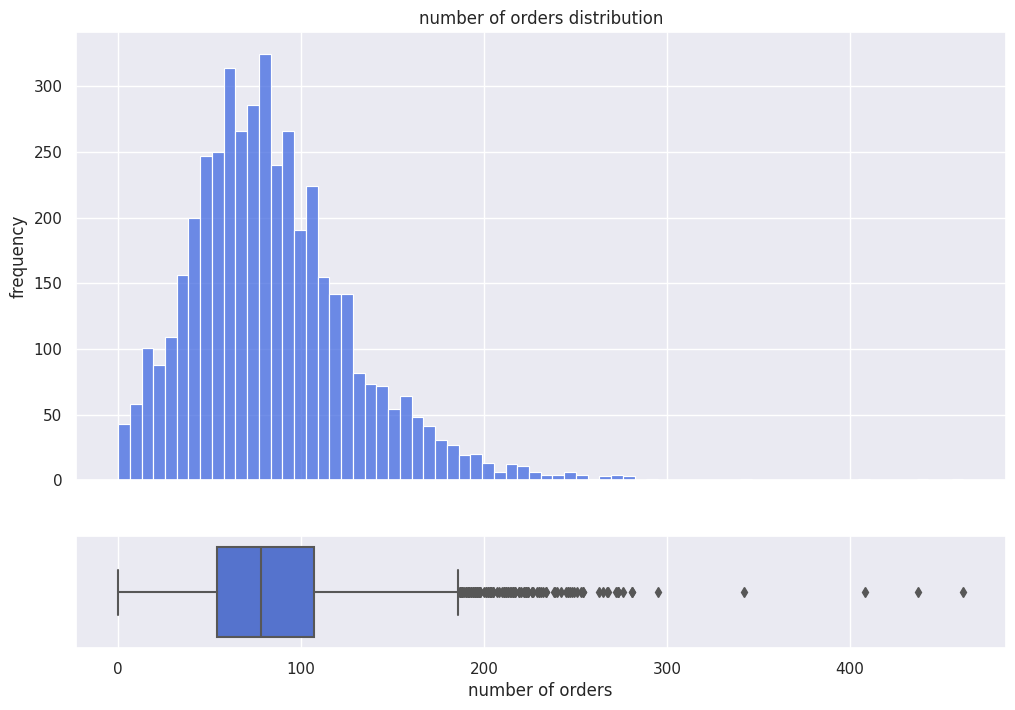

In [13]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['num_orders'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['num_orders'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='number of orders')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='number of orders distribution')
plt.show()

Таргет имеет логнормальное распределение.

Построим график скользящего среднего и стандартного отклонения.

In [14]:
data['rolling_mean'] = data['num_orders'].rolling(50).mean()
data['rolling_std'] = data['num_orders'].rolling(50).std()

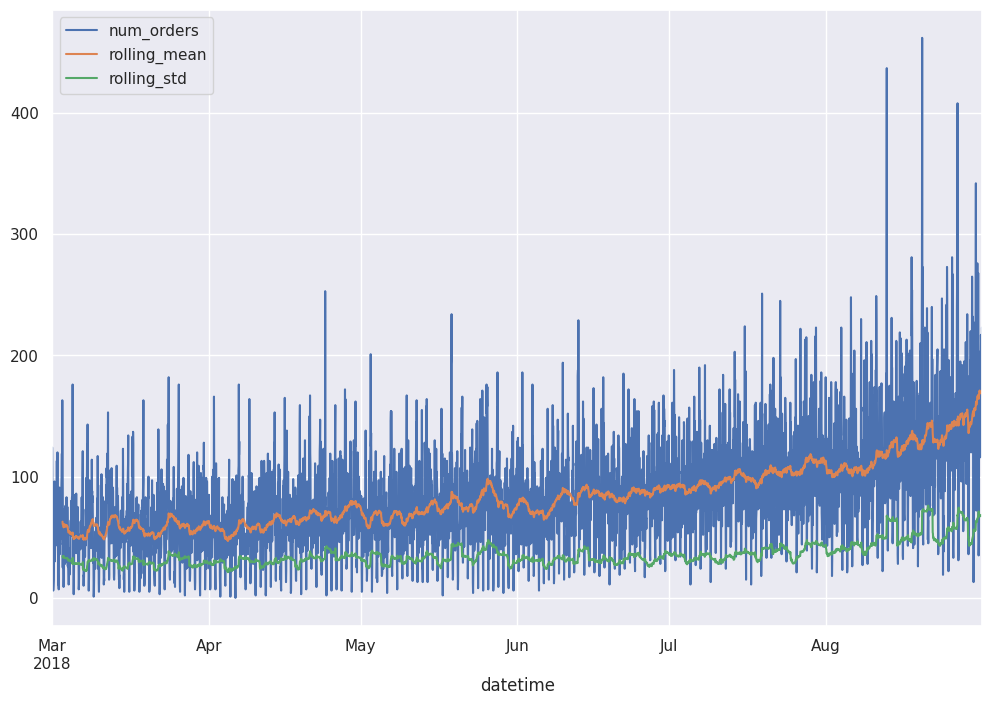

In [15]:
plt.figure(figsize=(12, 8))
data['num_orders'].plot(ax=plt.gca())
data['rolling_mean'].plot(ax=plt.gca())
data['rolling_std'].plot(ax=plt.gca())
plt.legend()

На графике можно увидеть, что среднее, как и стандартное отклонение, со временем возрастают. Значит ряд является нестационарным.

Проанализируем тренды и сезонность временного ряда.

In [16]:
decomposed = seasonal_decompose(data['num_orders'])

Text(0.5, 1.0, 'Trend')

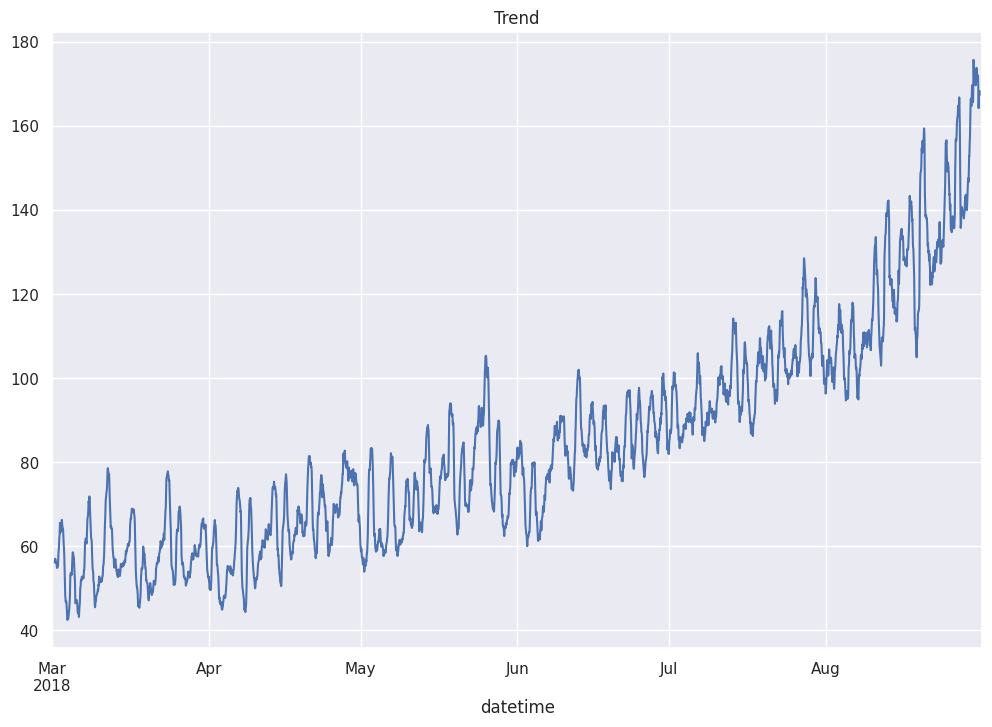

In [17]:
plt.figure(figsize=(12, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Тренд показывает, что временной ряд непрерывно возрастает на протяжении всего промежутка.

Text(0.5, 1.0, 'Seasonal')

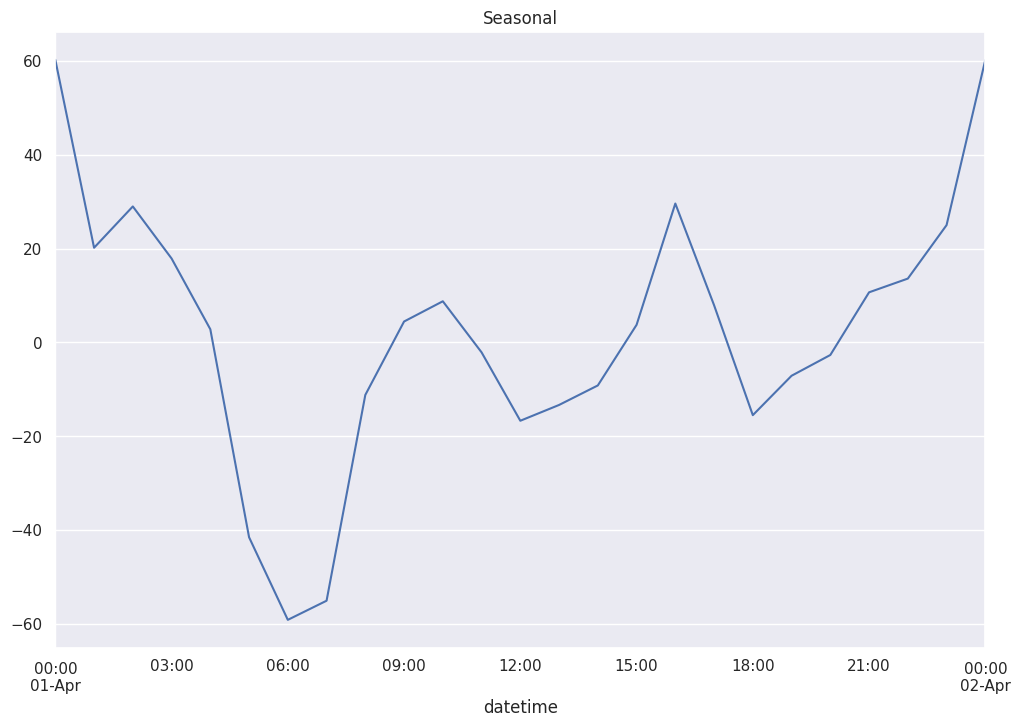

In [18]:
plt.figure(figsize=(12, 8))
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonal')

Сезонность графика имеет цикличность с периодом в 24 часа. Пик заказов такси приходится на 00:00, а минимум на 6:00.

Чтобы сделать ряд стационарным, найдем его разность.

In [19]:
data['num_orders'] = data['num_orders'] - data['num_orders'].shift()
data['rolling_mean'] = data['num_orders'].rolling(50).mean()
data['rolling_std'] = data['num_orders'].rolling(50).std()

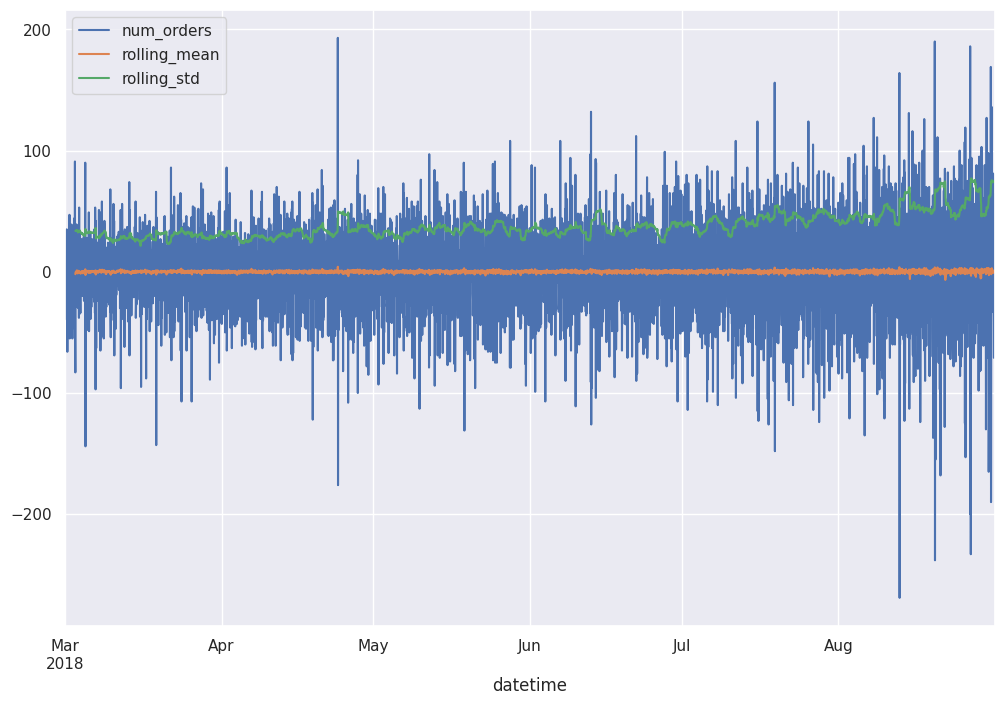

In [20]:
plt.figure(figsize=(12, 8))
data['num_orders'].plot(ax=plt.gca())
data['rolling_mean'].plot(ax=plt.gca())
data['rolling_std'].plot(ax=plt.gca())
plt.legend()

После нахождения разности временного ряда его среднее и стандартное отклонение перестали возрастать. Ряд стал стационарным.

Сгенерируем фичи для обучения моделей. Сгенерируем календарные: день, день недели, месяц и час; смещения и скользящие средние.

In [21]:
data = data.drop(columns=['rolling_mean', 'rolling_std'], axis=1)

In [22]:
def make_features(data, max_lag, rolling_mean_sizes):
  data['month'] = data.index.month
  data['day'] = data.index.day
  data['day_of_week'] = data.index.dayofweek
  data['hour'] = data.index.hour

  for i in range(max_lag):
    data[f'lag_{i+1}'] = data['num_orders'].shift(i+1)

  for rolling_mean_size in rolling_mean_sizes:
    data[f'rolling_mean_{rolling_mean_size}'] = data['num_orders'].rolling(rolling_mean_size).mean()

  data.dropna(inplace=True)

In [23]:
make_features(data, 10, [5, 10, 20, 50, 100])

Посмотрим на получившийся датасет.

In [24]:
data.head()

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_5,rolling_mean_10,rolling_mean_20,rolling_mean_50,rolling_mean_100
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,-17.0,3,5,0,4,19.0,-144.0,90.0,18.0,-15.0,8.0,-2.0,21.0,-24.0,29.0,-6.8,-4.6,-0.25,0.18,-0.90
2018-03-05 05:00:00,-18.0,3,5,0,5,-17.0,19.0,-144.0,90.0,18.0,-15.0,8.0,-2.0,21.0,-24.0,-14.0,-4.0,-1.15,-0.96,-0.69
2018-03-05 06:00:00,-13.0,3,5,0,6,-18.0,-17.0,19.0,-144.0,90.0,18.0,-15.0,8.0,-2.0,21.0,-34.6,-7.4,-0.80,-0.82,-0.68
2018-03-05 07:00:00,11.0,3,5,0,7,-13.0,-18.0,-17.0,19.0,-144.0,90.0,18.0,-15.0,8.0,-2.0,-3.6,-6.1,-1.35,-0.02,-0.52
2018-03-05 08:00:00,17.0,3,5,0,8,11.0,-13.0,-18.0,-17.0,19.0,-144.0,90.0,18.0,-15.0,8.0,-4.0,-5.2,0.05,0.44,-0.12


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4316 entries, 2018-03-05 04:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   num_orders        4316 non-null   float64
 1   month             4316 non-null   int64  
 2   day               4316 non-null   int64  
 3   day_of_week       4316 non-null   int64  
 4   hour              4316 non-null   int64  
 5   lag_1             4316 non-null   float64
 6   lag_2             4316 non-null   float64
 7   lag_3             4316 non-null   float64
 8   lag_4             4316 non-null   float64
 9   lag_5             4316 non-null   float64
 10  lag_6             4316 non-null   float64
 11  lag_7             4316 non-null   float64
 12  lag_8             4316 non-null   float64
 13  lag_9             4316 non-null   float64
 14  lag_10            4316 non-null   float64
 15  rolling_mean_5    4316 non-null   float64
 16

## Обучение моделей.

Разобьем датасет на обучающую, валидационную и тестовую выборку в соотношении 8:1:1.

In [26]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)
data_valid, data_test = train_test_split(data_test, test_size=0.5, shuffle=False)

In [27]:
data_train.index.min(), data_train.index.max()

(Timestamp('2018-03-05 04:00:00', freq='H'),
 Timestamp('2018-07-26 23:00:00', freq='H'))

In [28]:
data_valid.index.min(), data_valid.index.max()

(Timestamp('2018-07-27 00:00:00', freq='H'),
 Timestamp('2018-08-13 23:00:00', freq='H'))

In [29]:
data_test.index.min(), data_test.index.max()

(Timestamp('2018-08-14 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [30]:
x_train = data_train.drop(columns=['num_orders'], axis=1)
y_train = data_train['num_orders']

x_valid = data_valid.drop(columns=['num_orders'], axis=1)
y_valid = data_valid['num_orders']

x_test = data_test.drop(columns=['num_orders'], axis=1)
y_test = data_test['num_orders']

In [31]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((3452, 19), (3452,), (432, 19), (432,), (432, 19), (432,))

Данные разделились на выборки корректно.

Обучим модель случайного леса.

In [32]:
def objective(trial):
  params = {"max_depth": trial.suggest_int("max_depth", 6, 20),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
             'n_estimators': trial.suggest_int('n_estimators', 10, 1600, log=True),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }
  model = RandomForestRegressor(**params, random_state=987)
  model.fit(x_train, y_train)
  predicted_valid = model.predict(x_valid)
  return mean_squared_error(y_valid, predicted_valid) ** 0.5

In [33]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=20)

[I 2023-12-19 11:21:37,087] A new study created in memory with name: no-name-5f5e66bc-eb1b-4c45-824c-4477d07d059c


In [34]:
print('best params:', study.best_params)

best params: {'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 1598, 'min_samples_split': 7}


In [35]:
best_model = RandomForestRegressor(**study.best_params, random_state=987)

In [36]:
best_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=6, min_samples_split=7,
                      n_estimators=1598, random_state=987)

In [37]:
pred = best_model.predict(x_valid)
rmse = mean_squared_error(y_valid, pred) ** 0.5
print("RMSE:", rmse)

RMSE: 29.722572097755908


Случайный лес выдал скор RMSE = 29.7.

Обучим модель градиентного бустинга.

In [38]:
cat_boost = CatBoostRegressor(verbose=250, random_state=987)

In [39]:
cat_boost.fit(x_train, y_train, eval_set=(x_valid, y_valid))

Learning rate set to 0.061855
0:	learn: 33.6231513	test: 46.7460734	best: 46.7460734 (0)	total: 55ms	remaining: 54.9s
250:	learn: 9.1907323	test: 20.6847931	best: 20.6847931 (250)	total: 963ms	remaining: 2.87s
500:	learn: 5.4582644	test: 17.5970270	best: 17.5970270 (500)	total: 1.87s	remaining: 1.86s
750:	learn: 3.6711690	test: 16.3994840	best: 16.3994840 (750)	total: 2.75s	remaining: 911ms
999:	learn: 2.6485149	test: 15.8686861	best: 15.8686861 (999)	total: 3.62s	remaining: 0us

bestTest = 15.86868612
bestIteration = 999



Градиентный бустинг достиг значительно лучшего результата, чем предыдущая модель. RMSE = 15.8.

Подберем архитектуру для нейронной сети и обучим ее.

Для нейронной сети требуется стандартизировать данные.

In [40]:
st_scaler = StandardScaler()

In [41]:
x_train = pd.DataFrame(st_scaler.fit_transform(x_train), columns=x_train.columns)

In [42]:
x_valid = pd.DataFrame(st_scaler.transform(x_valid), columns=x_valid.columns)

In [43]:
x_test = pd.DataFrame(st_scaler.transform(x_test), columns=x_test.columns)

In [44]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.FloatTensor(y_valid.values).reshape(y_valid.shape[0], 1)

x_test = torch.FloatTensor(x_test.values)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1)

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [46]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

In [47]:
n_in_neurons = x_train.shape[1]
n_out_neurons = 1

In [48]:
mse = MeanSquaredError(squared=False).to(device)
loss = nn.MSELoss()

In [49]:
samples = 15
h1 = list(range(200, 801, 50))
h2 = list(range(200, 801, 50))
h3 = list(range(300, 701, 50))
h4 = list(range(300, 701, 50))
h5 = list(range(300, 701, 50))

In [50]:
for i in range(samples):
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]
    n_hidden_neurons_4 = h4[np.random.randint(0, len(h4))]
    n_hidden_neurons_5 = h5[np.random.randint(0, len(h5))]

    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Dropout(p=0.5),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(n_hidden_neurons_5, n_out_neurons),
        nn.ReLU()
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    num_epochs = 1000

    for epoch in range(num_epochs):
      optimizer.zero_grad()

      preds = net.forward(x_train)

      loss_value = loss(preds, y_train)
      loss_value.backward()

      optimizer.step()

    net.eval()
    rmse = mse(net.forward(x_valid), y_valid)
    print(f"h1: {n_hidden_neurons_1} h2: {n_hidden_neurons_2} h3: {n_hidden_neurons_3} h4:{n_hidden_neurons_4} h5:{n_hidden_neurons_5} rmse: {rmse}")

h1: 450 h2: 350 h3: 400 h4:550 h5:450 rmse: 34.9494514465332
h1: 450 h2: 700 h3: 400 h4:350 h5:300 rmse: 34.87776184082031
h1: 250 h2: 400 h3: 450 h4:550 h5:650 rmse: 34.94171905517578
h1: 450 h2: 350 h3: 300 h4:600 h5:300 rmse: 35.10050964355469
h1: 600 h2: 350 h3: 450 h4:300 h5:450 rmse: 34.96965026855469
h1: 350 h2: 400 h3: 500 h4:550 h5:700 rmse: 35.26274871826172
h1: 450 h2: 200 h3: 650 h4:600 h5:300 rmse: 36.308528900146484
h1: 450 h2: 200 h3: 550 h4:550 h5:400 rmse: 36.12873840332031
h1: 500 h2: 800 h3: 550 h4:650 h5:450 rmse: 34.800453186035156
h1: 300 h2: 400 h3: 400 h4:450 h5:500 rmse: 34.8682861328125
h1: 300 h2: 300 h3: 700 h4:500 h5:350 rmse: 35.44978332519531
h1: 700 h2: 400 h3: 500 h4:600 h5:300 rmse: 34.99245071411133
h1: 550 h2: 400 h3: 550 h4:600 h5:350 rmse: 34.85702133178711
h1: 300 h2: 750 h3: 350 h4:650 h5:700 rmse: 34.977935791015625
h1: 200 h2: 350 h3: 600 h4:450 h5:400 rmse: 34.94783020019531


Лучшей метрики достигла нейронная сеть с пятью скрытыми слоями с 500, 800, 550, 650 и 450 нейронами в скрытых слоях.

RMSE = 34.8.

## Тестирование лучшей модели.

Лучшей моделью на валидационной выборке оказался градиентный бустинг. Обучим модель на обучающей и валидационной выборке и протестируем на тестовой.

In [51]:
x_train = pd.DataFrame(x_train.to('cpu').numpy(), columns=data.drop(columns=['num_orders'], axis=1).columns)
y_train = pd.DataFrame(y_train.to('cpu').numpy(), columns=['num_orders'])

x_valid = pd.DataFrame(x_valid.to('cpu').numpy(), columns=data.drop(columns=['num_orders'], axis=1).columns)
y_valid = pd.DataFrame(y_valid.to('cpu').numpy(), columns=['num_orders'])

x_test = pd.DataFrame(x_test.to('cpu').numpy(), columns=data.drop(columns=['num_orders'], axis=1).columns)
y_test = pd.DataFrame(y_test.to('cpu').numpy(), columns=['num_orders'])

In [52]:
x_train_and_valid = pd.concat([x_train, x_valid])
y_train_and_valid = pd.concat([y_train, y_valid])

In [54]:
cat_boost.fit(x_train_and_valid, y_train_and_valid)

Learning rate set to 0.050732
0:	learn: 35.5125377	total: 5.2ms	remaining: 5.19s
250:	learn: 10.9511084	total: 916ms	remaining: 2.73s
500:	learn: 6.7125591	total: 1.86s	remaining: 1.85s
750:	learn: 4.6905488	total: 2.8s	remaining: 929ms
999:	learn: 3.4835817	total: 3.69s	remaining: 0us


In [55]:
print('rmse:', mean_squared_error(y_test, cat_boost.predict(x_test)) ** 0.5)

rmse: 21.536992304449907


Метрика RMSE на тестовой выборке составила 21.5.

## Интерпретация модели

In [56]:
explainer = shap.TreeExplainer(cat_boost)
shap_values = explainer.shap_values(x_train_and_valid)

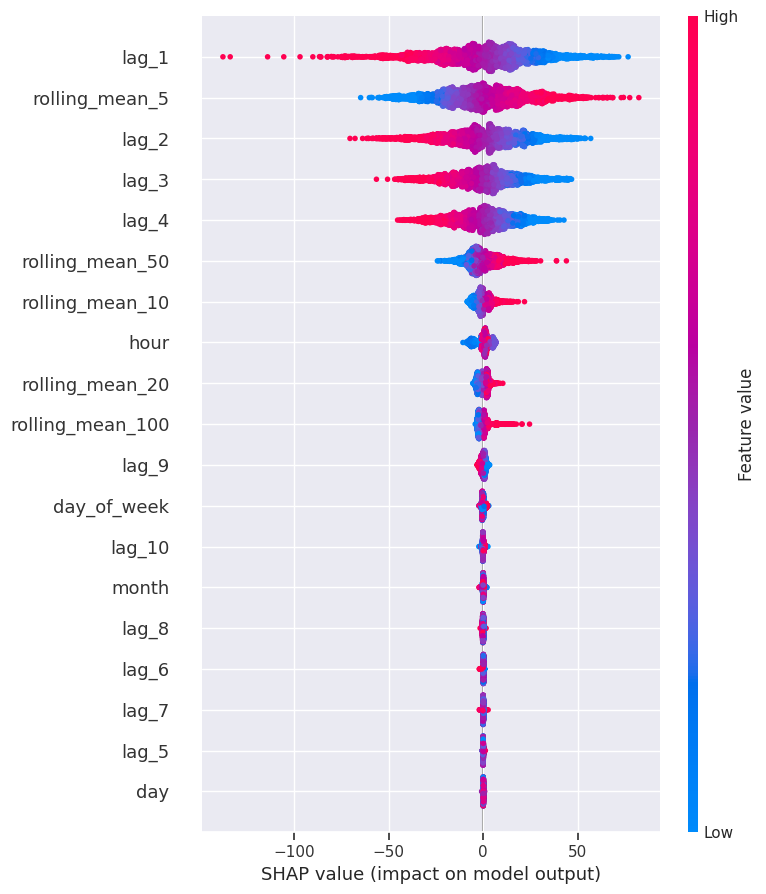

In [57]:
shap.summary_plot(shap_values, x_train_and_valid)

График показывает, что чем меньше значение фичей lag, тем к большим значениям предсказаний это приводит, и чем больше значение скользящих средних, тем к больше получаются значения предсказаний.

Самое сильное влияние на модель оказывают: lag_1, lag_2, lag_3, lag_4 и rolling_mean_5, rolling_mean_10, rolling_mean_50.

**ВЫВОД**

**В ходе выполнения проекта были загружены данные о количестве заказов такси в 10-минутные промежутки с марта по август 2018 года. Этот временной ряд был ресемплирован по интервалу в один час, затем была проанализирована сезонность и тренды временного ряда, сгенерированы фичи для обучения.**

**Для задачи предсказания количества заказов такси с горизонтом планирования в один час были обучены модели случайного леса, градиентного бустинга и полносвязной нейронной модели с пятью скрытыми слоями. Лучший результат дала модель градиентного бустинга.**

**Модель с наилучшим результатом была протестирована на тестовой выборке, было проинтерпретировано влияние фичей на предсказания модели.**

**С помощью модели градиентного бустинга удалось добиться наилучшей метрики RMSE = 21.5**